# Challenge 1

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore
from scipy.stats import boxcox

## Preprocess Datasets

### Load Datasets

In [30]:
df_omie_labelled = pd.read_csv('data\\df_omie_labelled.csv')
filtered_categories = pd.read_csv('data\\filtered_categories.csv')
df_omie_blind = pd.read_csv('data\\df_omie_blind.csv')
unit_list = pd.read_csv('data\\unit_list.csv')

In [88]:
print("df_omie_labelled")
df_omie_labelled.head(2)

df_omie_labelled


,Codigo,Descripcion,fechaHora,PrecEuro,Energia,hour,day_of_week,month,Energia_lag_1,Energia_lag_6,Energia_lag_24,mean,median,std
0,ADXRE01,PREAL1,2024-02-29,0.0,0.0,0,3,2,NaN,NaN,NaN,0.898092,0.0,8.872949
1,ADXVD03,PV ALARCOS,2024-02-29,0.0,0.0,0,3,2,0.0,NaN,NaN,78.237178,16.2,92.429915


In [89]:
print("df_omie_blind")
df_omie_blind.head(2)

df_omie_blind


,fechaHora,PrecEuro,Energia,hour,day_of_week,month
0,2024-06-01 23:00:00,0.0,0.0,23,5,6
2,2024-06-01 23:00:00,-20.0,11.9,23,5,6


In [90]:
print("filtered_categories")
filtered_categories.head(2)

filtered_categories


,Categoria,Codigo
0,Eolica,ADXVD04
1,Eolica,CEVD053


In [91]:
print("unit_list")
unit_list.head(2)

unit_list


,Codigo,Descripción,Agente,Porcentaje_Propiedad,Tipo_Unidad,Zona/Frontera,Tecnología
0,AFIBGEC,ALMACENAMIENTO COMPRA,IBERDROLA ENERGÍA ESPAÑA S..A.,100.0,ALMACENAMIENTO,ZONA ESPAÑOLA,Almacenamiento Compra
1,AFIBHEC,COMPRA HIBRIDACION EOLICA BAT,IBERDROLA ENERGÍA ESPAÑA S..A.,100.0,ALMACENAMIENTO,ZONA ESPAÑOLA,Almacenamiento Compra


### Cleaning

#### Missing Data

In [35]:
print(f"df_omie_labelled: \n{df_omie_labelled.isnull().sum()}")
print(f"\nfiltered_categories:\n{filtered_categories.isnull().sum()}")
print(f"\ndf_omie_blind: \n{df_omie_blind.isnull().sum()}")
print(f"\nunit_list: \n{unit_list.isnull().sum()}")

df_omie_labelled: 
Codigo         0
Descripcion    0
fechaHora      0
PrecEuro       0
Energia        0
dtype: int64

filtered_categories:
Categoria    0
Codigo       0
dtype: int64

df_omie_blind: 
fechaHora    0
PrecEuro     0
Energia      0
dtype: int64

unit_list: 
Codigo                   0
Descripción              0
Agente                   0
Porcentaje_Propiedad     0
Tipo_Unidad              0
Zona/Frontera            0
Tecnología              16
dtype: int64


In [43]:
unit_list["Tecnología"] = unit_list["Tecnología"].fillna("Unknown")

#### Duplicates

In [37]:
print(df_omie_labelled.drop_duplicates(inplace=True))
print(df_omie_blind.drop_duplicates(inplace=True))

None
None


#### Conversions 

In [50]:
df_omie_labelled['fechaHora'] = pd.to_datetime(df_omie_labelled['fechaHora'])
df_omie_blind['fechaHora'] = pd.to_datetime(df_omie_blind['fechaHora'])

print(df_omie_labelled['fechaHora'].dtype)  
print(df_omie_blind['fechaHora'].dtype)

datetime64[ns]
datetime64[ns]


In [115]:
# filtered_categories['Categoria'] = filtered_categories['Categoria'].astype('category')
# print(filtered_categories['Categoria'].cat.categories)


Index(['Eolica', 'Solar'], dtype='object')


#### Normalize Data for Testing Different Models - Later on

In [117]:
columns_norm = ["PrecEuro", "Energia"]

# MIN MAX SCALER (0-1)
minmax_scaler = MinMaxScaler()
df_minmax = df_omie_labelled.copy()
df_minmax[columns_norm] = minmax_scaler.fit_transform(df_omie_labelled[columns_norm])

# STANDARD SCALAR (MEAN:0, STD: 1)
standard_scaler = StandardScaler()
df_standardized = df_omie_labelled.copy()
df_standardized[columns_norm] = standard_scaler.fit_transform(df_omie_labelled[columns_norm])


### Feature Engineering

#### Time Based Features

In [118]:
df_omie_labelled['hour'] = df_omie_labelled['fechaHora'].dt.hour
df_omie_blind['hour'] = df_omie_blind['fechaHora'].dt.hour
df_omie_labelled['day_of_week'] = df_omie_labelled['fechaHora'].dt.dayofweek
df_omie_blind['day_of_week'] = df_omie_blind['fechaHora'].dt.dayofweek
df_omie_labelled['month'] = df_omie_labelled['fechaHora'].dt.month
df_omie_blind['month'] = df_omie_blind['fechaHora'].dt.month

In [119]:
for lag in [1, 6, 24]:      #1/6/24 hours
    df_omie_labelled[f'Energia_lag_{lag}'] = df_omie_labelled['Energia'].shift(lag)


### Merge Datasets

In [123]:
df = pd.merge(df_omie_labelled, filtered_categories, on='Codigo', how='left')
# df.info()

In [121]:
df = pd.merge(df, unit_list, on='Codigo', how='left')
df = df.drop(columns=['Descripción', 'Agente', 'Porcentaje_Propiedad', 'Tipo_Unidad', 'Zona/Frontera'])
# df.info()

In [122]:
df = pd.get_dummies(df, columns=["Categoria", "Tecnología"], drop_first=True)
# df.info()

## EDA

In [124]:
df.head(3)

,Codigo,Descripcion,fechaHora,PrecEuro,Energia,hour,day_of_week,month,Energia_lag_1,Energia_lag_6,Energia_lag_24,mean,median,std,Categoria
0,ADXRE01,PREAL1,2024-02-29,0.0,0.0,0,3,2,NaN,NaN,NaN,0.898092,0.0,8.872949,Solar
1,ADXVD03,PV ALARCOS,2024-02-29,0.0,0.0,0,3,2,0.0,NaN,NaN,78.237178,16.2,92.429915,Solar
2,ADXVD04,EOLICA AUDAX,2024-02-29,-0.1,2.7,0,3,2,0.0,NaN,NaN,7.770098,5.2,7.511477,Eolica


In [100]:
df.describe()


,fechaHora,PrecEuro,Energia,hour,day_of_week,month
count,2409526,2.409526e+06,2.409526e+06,2.409526e+06,2.409526e+06,2.409526e+06
mean,2024-04-15 23:10:13.309671168,1.908406e+00,1.386135e+01,1.148980e+01,3.030169e+00,3.999556e+00
min,2024-02-29 00:00:00,-5.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
25%,2024-03-23 11:00:00,-1.000000e-01,0.000000e+00,5.000000e+00,1.000000e+00,3.000000e+00
50%,2024-04-15 23:30:00,0.000000e+00,8.000000e-01,1.100000e+01,3.000000e+00,4.000000e+00
75%,2024-05-09 11:00:00,0.000000e+00,9.100000e+00,1.700000e+01,5.000000e+00,5.000000e+00
max,2024-06-01 22:00:00,3.000000e+03,5.047000e+03,2.300000e+01,6.000000e+00,6.000000e+00
std,NaN,8.384482e+01,7.212333e+01,6.916773e+00,1.981050e+00,8.620461e-01


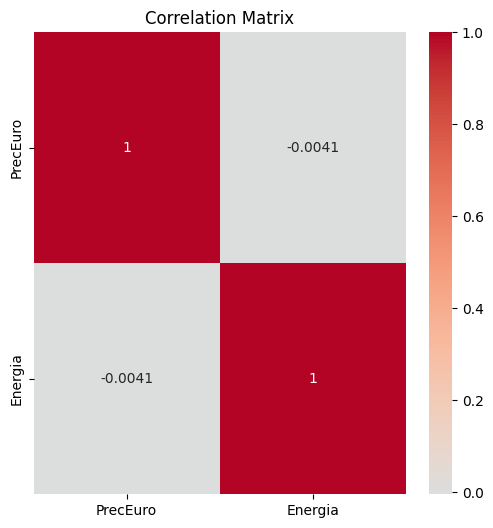

In [104]:
corr_matrix = df[['PrecEuro', 'Energia']].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

There is a very weak correlation between Energia and Precio (-0.0041). 

#### Energy Supply

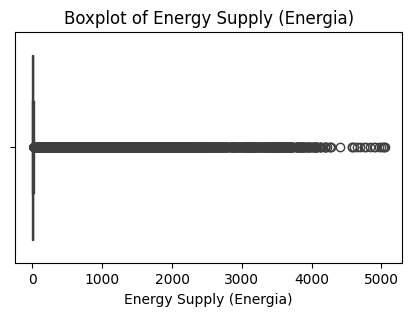

In [142]:
plt.figure(figsize=(5, 3))
sns.boxplot(x=df['Energia'])
plt.title('Boxplot of Energy Supply (Energia)')
plt.xlabel('Energy Supply (Energia)')
plt.show()

The Energia data is very [right] skewed, where the majority of the data is concentrated on the left (under 100) but a very long tail extends up to 5000. There are some extreme values in the dataset, which means very high variations. 

**Mean Energy Supply**

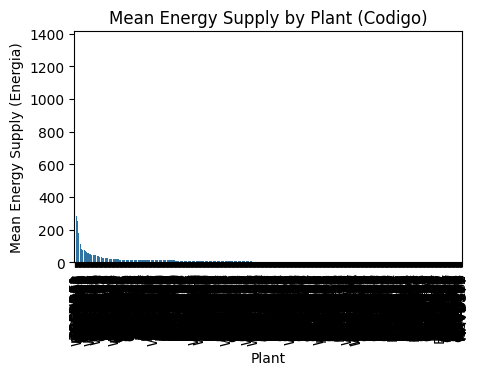

In [159]:
mean_energy_per_plant = df.groupby('Codigo')['Energia'].mean().sort_values(ascending=False)
plt.figure(figsize=(5, 3))
sns.barplot(x=mean_energy_per_plant.index, y=mean_energy_per_plant.values)
plt.title('Mean Energy Supply by Plant (Codigo)')
plt.xlabel('Plant')
plt.ylabel('Mean Energy Supply (Energia)')
plt.xticks(rotation=90)
plt.show()

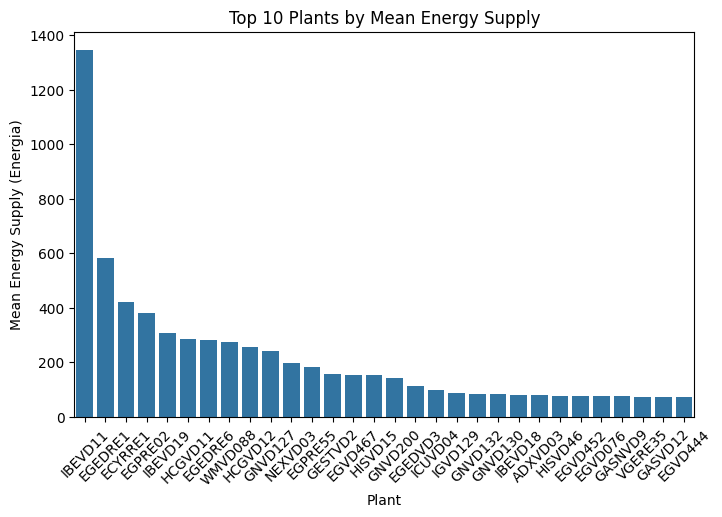

In [ ]:
top_n_plants = mean_energy_per_plant.head(30)  
plt.figure(figsize=(8, 5))
sns.barplot(x=top_n_plants.index, y=top_n_plants.values)
plt.title('Top 10 Plants by Mean Energy Supply')
plt.xlabel('Plant')
plt.ylabel('Mean Energy Supply (Energia)')
plt.xticks(rotation=45)
plt.show()


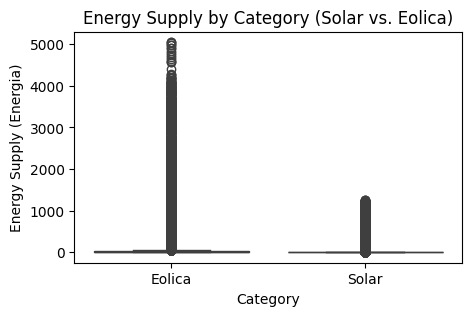

In [144]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='Categoria', y='Energia', data=df)
plt.title('Energy Supply by Category (Solar vs. Eolica)')
plt.xlabel('Category')
plt.ylabel('Energy Supply (Energia)')
plt.show()


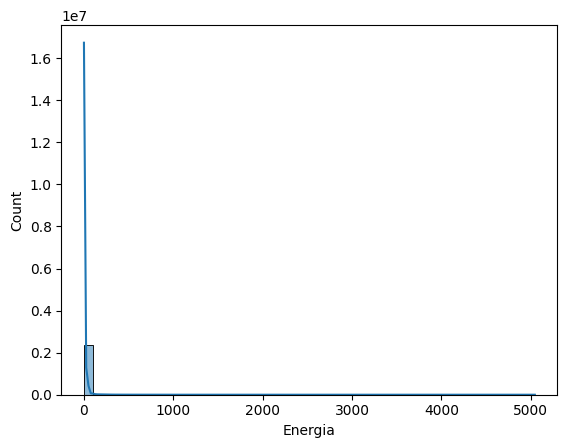

In [147]:
sns.histplot(df['Energia'], bins=50, kde=True)
plt.show()

**Outlier Handling**

In [149]:
Q1 = df['Energia'].quantile(0.25)
Q3 = df['Energia'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


iqr_outliers = df[(df['Energia'] < lower_bound) | (df['Energia'] > upper_bound)]
iqr_non_outliers = df[(df['Energia'] >= lower_bound) & (df['Energia'] <= upper_bound)]
print(f"IQR Outliers detected: {len(iqr_outliers)}")
print(f"IQR Non-Outliers detected: {len(iqr_non_outliers)}")


z_scores = zscore(df['Energia'])
z_outliers = df[np.abs(z_scores) > 3]
z_non_outliers = df[np.abs(z_scores) <= 3]
print(f"Z-Score Outliers detected: {len(z_outliers)}")
print(f"Z-Score Non-Outliers detected: {len(z_non_outliers)}")


median = np.median(df['Energia'])
mad = np.median(np.abs(df['Energia'] - median))
modified_z = 0.6745 * (df['Energia'] - median) / mad
mz_outliers = df[np.abs(modified_z) > 3.5]
mz_non_outliers = df[np.abs(modified_z) <= 3.5]
print(f"Modified Z-Score Outliers detected: {len(mz_outliers)}")
print(f"Modified Z-Score Non-Outliers detected: {len(mz_non_outliers)}")


capped_df = df.copy()
capped_df['Energia'] = np.clip(df['Energia'], lower_bound, upper_bound)


IQR Outliers detected: 335817
IQR Non-Outliers detected: 2073709
Z-Score Outliers detected: 20549
Z-Score Non-Outliers detected: 2388977
Modified Z-Score Outliers detected: 775433
Modified Z-Score Non-Outliers detected: 1634093


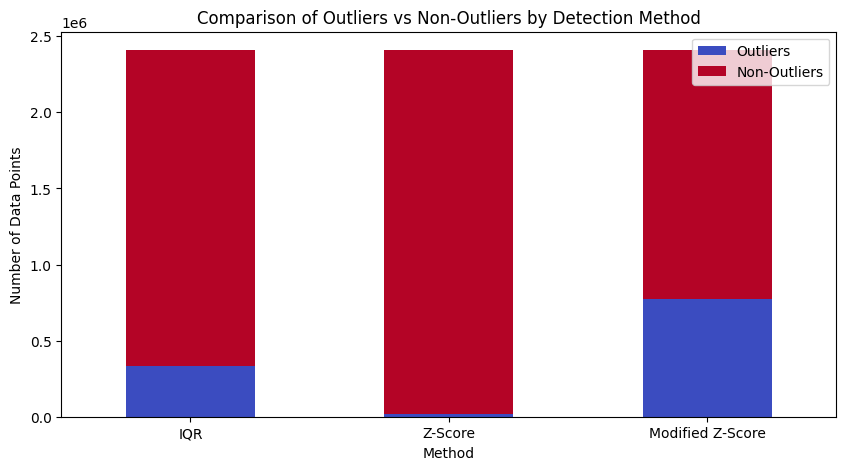

In [157]:
outlier_counts = pd.DataFrame({
    'Method': ['IQR', 'Z-Score', 'Modified Z-Score'],
    'Outliers': [len(iqr_outliers), len(z_outliers), len(mz_outliers)], 'Non-Outliers': [len(iqr_non_outliers), len(z_non_outliers), len(mz_non_outliers)] })

outlier_counts.set_index('Method').plot(kind='bar', stacked=True, figsize=(10,5), colormap='coolwarm') 
plt.ylabel("Number of Data Points") 
plt.title("Comparison of Outliers vs Non-Outliers by Detection Method") 
plt.legend(["Outliers", "Non-Outliers"]) 
plt.xticks(rotation=0) 
plt.show()

The data is skewed with a extremely long tail, where the data does not have a normal pattern/distribution. There is a significant number of outliers but 86.1% of the datapoints are still within in the normal range. 

Using the Modified Z-Score, which is the best for non normal data, there is a 32.2% detection of outliers. 

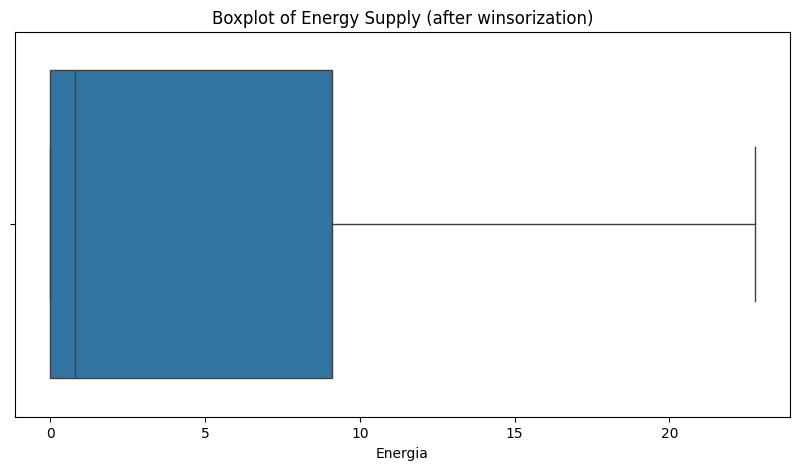

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x=capped_df['Energia'])
plt.title("Boxplot of Energy Supply (after winsorization)")
plt.show()

In [154]:
original_stats = df['Energia'].describe()
print(original_stats)
print(f"Median: {df['Energia'].median()}")

count    2.409526e+06
mean     1.386135e+01
std      7.212333e+01
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e-01
75%      9.100000e+00
max      5.047000e+03
Name: Energia, dtype: float64
Median: 0.8


Considering the datapoints in our dataset are all relevant, we are only looking at the winsorization of the data to understand better the majority of the data without the extreme outliers. This shows us that the majority of the data is within 0-9.1, but the median is 0.8 while the mean is 13.86 and the STD is 72.12. This is due to a few outliers.

C:\Users\annap\AppData\Local\Temp\ipykernel_2816\1144866721.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_energy_by_category = df.groupby('Categoria')['Energia'].mean()


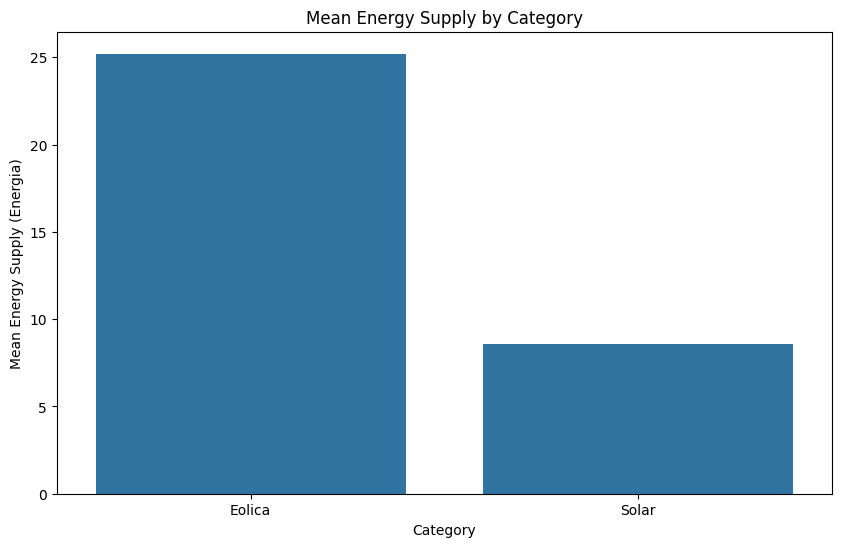

In [129]:
mean_energy_by_category = df.groupby('Categoria')['Energia'].mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_energy_by_category.index, y=mean_energy_by_category.values)
plt.title('Mean Energy Supply by Category')
plt.xlabel('Category')
plt.ylabel('Mean Energy Supply (Energia)')
plt.show()


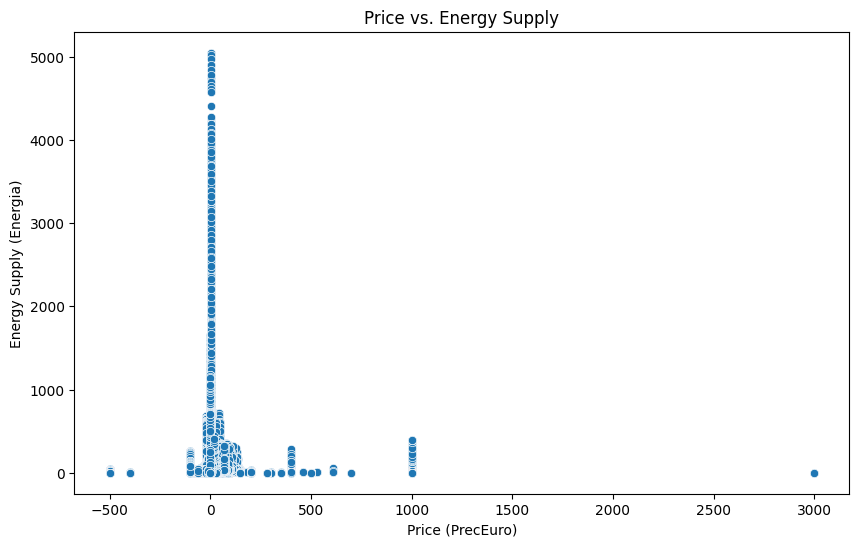

          PrecEuro   Energia
PrecEuro  1.000000 -0.004134
Energia  -0.004134  1.000000


In [130]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PrecEuro', y='Energia', data=df)
plt.title('Price vs. Energy Supply')
plt.xlabel('Price (PrecEuro)')
plt.ylabel('Energy Supply (Energia)')
plt.show()

correlation = df[['PrecEuro', 'Energia']].corr()
print(correlation)


                 Energia  Energia_lag_1  Energia_lag_6  Energia_lag_24
Energia         1.000000       0.078026       0.040626        0.023571
Energia_lag_1   0.078026       1.000000       0.082936        0.049656
Energia_lag_6   0.040626       0.082936       1.000000        0.007026
Energia_lag_24  0.023571       0.049656       0.007026        1.000000


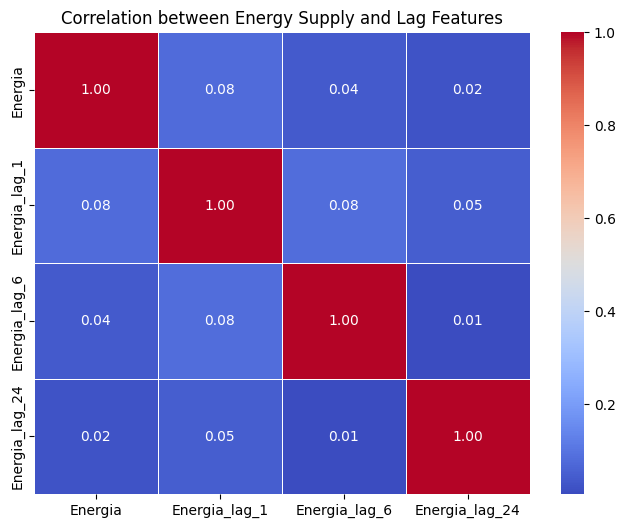

In [131]:
lag_features = ['Energia_lag_1', 'Energia_lag_6', 'Energia_lag_24']
correlation_lags = df[['Energia'] + lag_features].corr()
print(correlation_lags)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_lags, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation between Energy Supply and Lag Features')
plt.show()


In [132]:
Q1 = df['Energia'].quantile(0.25)
Q3 = df['Energia'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Energia'] < lower_bound) | (df['Energia'] > upper_bound)]
print(outliers)


          Codigo                     Descripcion           fechaHora  \
9        ASIVD06     SOLAR FV MAYOR O IGUAL 5 MW 2024-02-29 00:00:00   
18       CEVD209         STO. CRISTO DE MAGALLON 2024-02-29 00:00:00   
20       CEVD234                         CEVD234 2024-02-29 00:00:00   
28       CEVD284                       EOL. EBRO 2024-02-29 00:00:00   
29       CEVD287                    EOL. BANDERA 2024-02-29 00:00:00   
...          ...                             ...                 ...   
2409483  VGERE39                         VGERE39 2024-06-01 22:00:00   
2409489  VGERE47                          EARTIG 2024-06-01 22:00:00   
2409510  WMVD088  VENTA EXCED AUTOPROD WMARK 088 2024-06-01 22:00:00   
2409519  WMVD189  VENTA EXCED AUTOPROD WMARK 189 2024-06-01 22:00:00   
2409520  WMVD193  VENTA EXCED AUTOPROD WMARK 193 2024-06-01 22:00:00   

         PrecEuro  Energia  hour  day_of_week  month  Energia_lag_1  \
9            0.00     46.2     0            3      2            

### Time Based Visualizations

**Energy Supply Over Time Across All Plants**

**Hourly**

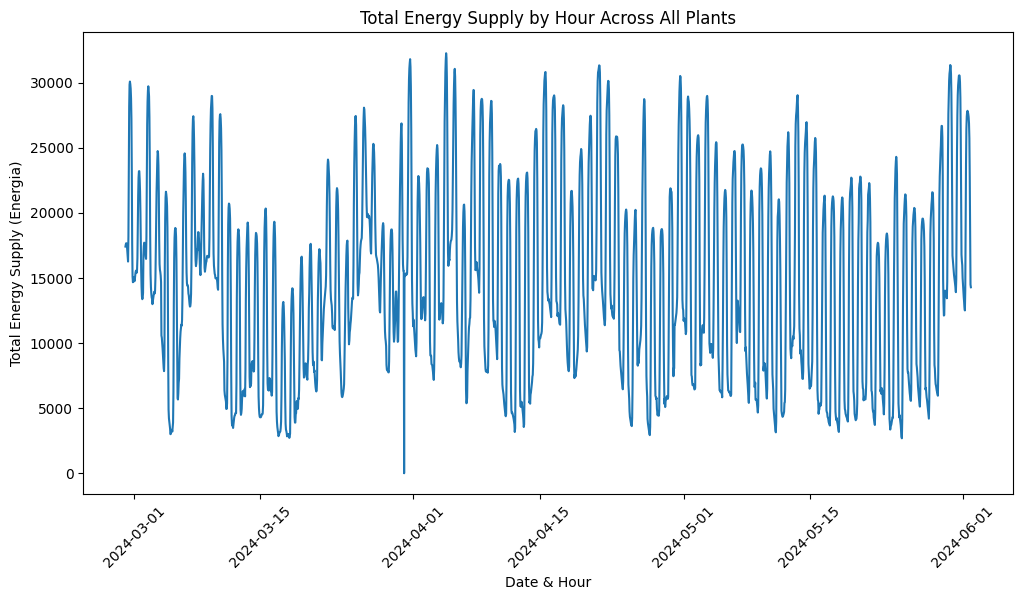

In [111]:
hourly_energy = df.resample('H', on='fechaHora')['Energia'].sum()

plt.figure(figsize=(12, 6))
plt.plot(hourly_energy.index, hourly_energy.values, label='Total Energy Supply')
plt.xlabel('Date & Hour')
plt.ylabel('Total Energy Supply (Energia)')
plt.title('Total Energy Supply by Hour Across All Plants')
plt.xticks(rotation=45)
plt.show()


**Daily**

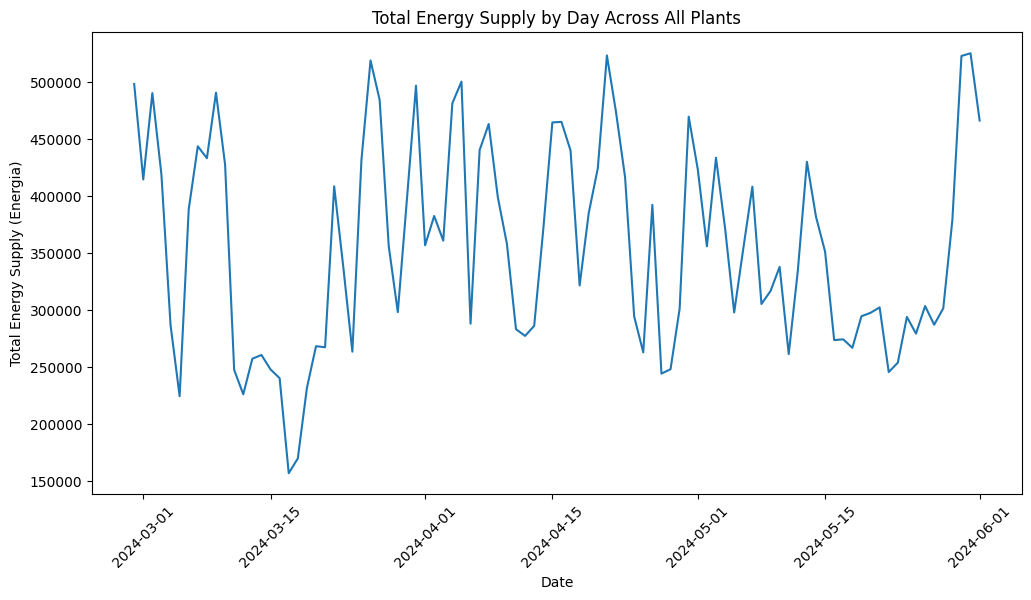

In [113]:
daily_energy = df.resample('D', on='fechaHora')['Energia'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_energy.index, daily_energy.values, label='Total Energy Supply')
plt.xlabel('Date')
plt.ylabel('Total Energy Supply (Energia)')
plt.title('Total Energy Supply by Day Across All Plants')
plt.xticks(rotation=45)
plt.show()

**Weekly**

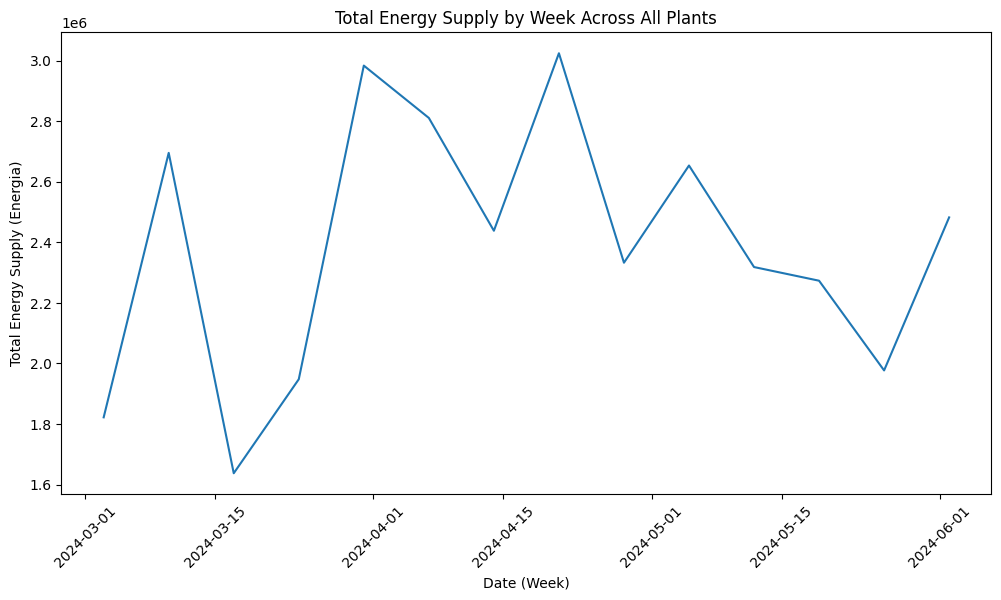

In [114]:
weekly_energy = df.resample('W', on='fechaHora')['Energia'].sum()

plt.figure(figsize=(12, 6))
plt.plot(weekly_energy.index, weekly_energy.values, label='Total Energy Supply')
plt.xlabel('Date (Week)')
plt.ylabel('Total Energy Supply (Energia)')
plt.title('Total Energy Supply by Week Across All Plants')
plt.xticks(rotation=45)
plt.show()

### Catagorial Feature Distributions